In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import pandas as pd

from expected_tackling.data.mott_features import compute_mott_features_data, sample_training_data, _find_peaks
from expected_tackling.visualization.metrics import plot_confusion_matrix

In [5]:
features_data = pd.concat([pd.read_csv(f"../data/features_week_{i}.csv") for i in range(1,10)]).reset_index(drop=True)
tackling_probability = pd.read_csv("../data/tackling_probability.csv")
tackles = pd.read_csv("../data/tackles.csv")

In [16]:
peak_example = features_data[
    (features_data["gameId"]==2022091106) &
    (features_data["playId"]==2405) &
    (features_data["nflId"]==52991)
][
    ["gameId", "playId", "nflId", "frameId", "distance_to_ball_carrier", "ball_carrier_distance_to_endzone"]
].merge(tackling_probability, on=["gameId", "playId", "nflId", "frameId"])

peak_example["ott"] = peak_example["tackling_probability"] / peak_example["distance_to_ball_carrier"]
predicted_peaks = _find_peaks(peak_example["ott"])


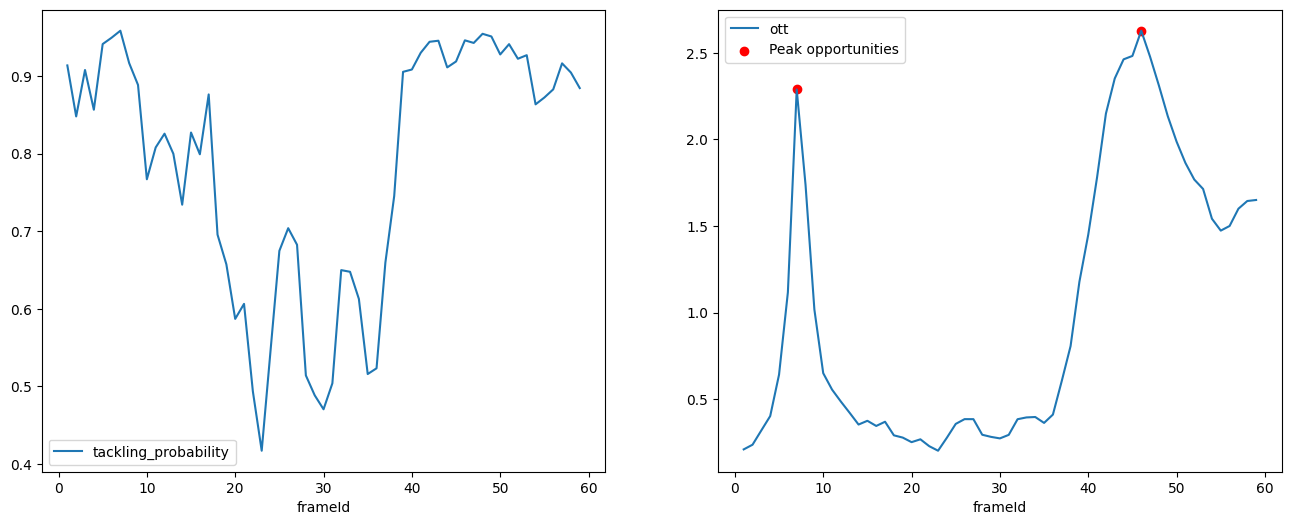

In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
peak_example.plot(x="frameId", y="tackling_probability", ax=axes[0])
peak_example.plot(x="frameId", y="ott", ax=axes[1])
axes[1].scatter(peak_example.loc[predicted_peaks, "frameId"], peak_example.loc[predicted_peaks, "ott"], color='red', label="Peak opportunities")
axes[1].legend()
plt.savefig("../reports/figures/peak_detection", bbox_inches="tight")

In [21]:
mott_features_data = compute_mott_features_data(features_data, tackling_probability, tackles)

In [22]:
mott_features_data

ott  \
gameId     playId nflId   opportunityId frameId             
2022090800 56     38577.0 0             15.0     0.158333   
                  41239.0 0             10.0     0.000607   
                  42816.0 0             6.0      0.001262   
                  43294.0 0             18.0     1.046483   
                  43298.0 0             2.0      0.000308   
...                                                   ...   
2022110700 3787   52627.0 0             25.0     0.012055   
                  53460.0 0             23.0     0.115559   
                  53533.0 0             40.0     0.001109   
                  54541.0 0             33.0     1.136388   
                  54606.0 0             37.0     0.005385   

                                                 mean_distance_to_ball_carrier_from_peak  \
gameId     playId nflId   opportunityId frameId                                            
2022090800 56     38577.0 0             15.0                                    1.971121   
                  41239.0 0             10.0                                   13.907379   
                  42816.0 0             6.0                                    27.279112   
                  43294.0 0             18.0                                    0.670298   
                  43298.0 0             2.0                                    12.350122   
...                                                                                  ...   
2022110700 3787   52627.0 0             25.0                                   13.470441   
                  53460.0 0             23.0                                    4.405723   
                  53533.0 0             40.0                                   19.715603   
                  54541.0 0             33.0                                    1.121133   
                  54606.0 0             37.0                                   12.675541   

                                                 ball_carrier_distance_won_to_last_frame  \
gameId     playId nflId   opportunityId frameId                                            
2022090800 56     38577.0 0             15.0                                        0.00   
                  41239.0 0             10.0                                        0.00   
                  42816.0 0             6.0                                         0.52   
                  43294.0 0             18.0                                        0.00   
                  43298.0 0             2.0                                         1.15   
...                                                                                  ...   
2022110700 3787   52627.0 0             25.0                                        5.57   
                  53460.0 0             23.0                                        6.54   
                  53533.0 0             40.0                                        0.00   
                  54541.0 0             33.0                                        1.95   
                  54606.0 0             37.0                                        0.59   

                                                 tackle_or_assist  \
gameId     playId nflId   opportunityId frameId                     
2022090800 56     38577.0 0             15.0                  0.0   
                  41239.0 0             10.0                  0.0   
                  42816.0 0             6.0                   0.0   
                  43294.0 0             18.0                  1.0   
                  43298.0 0             2.0                   0.0   
...                                                           ...   
2022110700 3787   52627.0 0             25.0                  0.0   
                  53460.0 0             23.0                  0.0   
                  53533.0 0             40.0                  0.0   
                  54541.0 0             33.0                  0.0   
                  54606.0 0           

In [23]:
mott_features_data["pff_missedTackle"].value_counts()

pff_missedTackle
0.0    127349
1.0      2060
Name: count, dtype: int64

In [51]:
mott_features_data[~mott_features_data.index.droplevel([3, 4]).duplicated(keep=False)]["pff_missedTackle"].value_counts()

pff_missedTackle
0.0    124662
1.0      1857
Name: count, dtype: int64

In [36]:
sample_mott_features_data = sample_training_data(mott_features_data)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from catboost import CatBoostClassifier

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    sample_mott_features_data.drop(columns=["pff_missedTackle"]), 
    sample_mott_features_data["pff_missedTackle"], 
    test_size=0.33, 
    random_state=42
)

In [39]:
model = CatBoostClassifier(max_depth=2, scale_pos_weight=5, verbose=0)
model.fit(X_train, y_train)

In [40]:
y_pred = model.predict(X_test)

In [41]:
y_test.sum()/len(y_test)

0.08358120166567519

In [42]:
y_pred.sum()/len(y_pred)

0.10350981558596074

In [43]:
balanced_accuracy_score(y_train, model.predict(X_train))

0.9601106042162499

In [44]:
balanced_accuracy_score(y_test, y_pred)

0.9600022408031778

In [45]:
confusion_matrix(y_train, model.predict(X_train))

array([[12068,   340],
       [   65,  1176]], dtype=int64)

In [46]:
confusion_matrix(y_test, y_pred)

array([[5998,  164],
       [  30,  532]], dtype=int64)

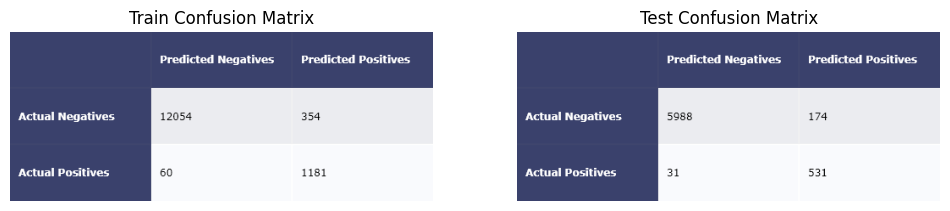

In [38]:
plot_confusion_matrix(
    confusion_matrix(y_train, model.predict(X_train)), 
    confusion_matrix(y_test, y_pred),
    name="mott_confusion_matrix"
)

In [42]:
import pickle
pickle.dump(model, open("../models/model_mott.pkl", 'wb'))

In [52]:
mott_features_data.to_csv("../data/features_mott.csv")

In [39]:
result_data = mott_features_data.copy()
result_data["prediction"] = model.predict(result_data.drop(columns=["pff_missedTackle"]))

In [40]:
result_data

ott  \
gameId     playId nflId   opportunityId             
2022090800 56     38577.0 0              0.158333   
                  41239.0 0              0.000607   
                  42816.0 0              0.001262   
                  43294.0 0              1.046483   
                  43298.0 0              0.000308   
...                                           ...   
2022110700 3787   52627.0 0              0.012055   
                  53460.0 0              0.115559   
                  53533.0 0              0.001109   
                  54541.0 0              1.136388   
                  54606.0 0              0.005385   

                                         mean_distance_to_ball_carrier_from_peak  \
gameId     playId nflId   opportunityId                                            
2022090800 56     38577.0 0                                             1.971121   
                  41239.0 0                                            13.907379   
                  42816.0 0                                            27.279112   
                  43294.0 0                                             0.670298   
                  43298.0 0                                            12.350122   
...                                                                          ...   
2022110700 3787   52627.0 0                                            13.470441   
                  53460.0 0                                             4.405723   
                  53533.0 0                                            19.715603   
                  54541.0 0                                             1.121133   
                  54606.0 0                                            12.675541   

                                         ball_carrier_distance_won_to_last_frame  \
gameId     playId nflId   opportunityId                                            
2022090800 56     38577.0 0                                                 0.00   
                  41239.0 0                                                 0.00   
                  42816.0 0                                                 0.52   
                  43294.0 0                                                 0.00   
                  43298.0 0                                                 1.15   
...                                                                          ...   
2022110700 3787   52627.0 0                                                 5.57   
                  53460.0 0                                                 6.54   
                  53533.0 0                                                 0.00   
                  54541.0 0                                                 1.95   
                  54606.0 0                                                 0.59   

                                         tackle_or_assist  pff_missedTackle  \
gameId     playId nflId   opportunityId                                       
2022090800 56     38577.0 0                           0.0               0.0   
                  41239.0 0                           0.0               0.0   
                  42816.0 0                           0.0               0.0   
                  43294.0 0                           1.0               0.0   
                  43298.0 0                           0.0               0.0   
...                                                   ...               ...   
2022110700 3787   52627.0 0                           0.0               0.0   
                  53460.0 0                           0.0               0.0   
                  53533.0 0                           0.0               0.0   
                  54541.0 0                           0.0               0.0   
                  54606.0 0                           0.0               0.0   

                                         prediction  
gameId     playId nflId   opportunityId              
2022090800 56     38577.0 0       

In [41]:
result_data.loc[(2022100911,2915)]

,,ott,mean_distance_to_ball_carrier_from_peak,ball_carrier_distance_won_to_last_frame,tackle_or_assist,pff_missedTackle,prediction
nflId,opportunityId,,,,,,
42401.0,0,0.000421,19.369486,7.07,0.0,0.0,0.0
43986.0,0,0.795232,4.820028,6.44,0.0,1.0,1.0
44848.0,0,0.018716,8.442979,1.66,0.0,0.0,0.0
47816.0,0,1.076127,3.278709,5.02,1.0,0.0,1.0
47848.0,0,0.001377,16.561179,7.89,0.0,0.0,0.0
49410.0,0,0.012372,9.991531,3.07,0.0,0.0,0.0
52416.0,0,0.605927,2.162725,3.48,0.0,0.0,1.0
52522.0,0,0.003440,10.140932,7.43,0.0,0.0,0.0
53445.0,0,0.032192,5.606291,0.00,0.0,0.0,0.0
